# Mental Health Program Discharge Survival Analysis and Modeling
Xiaoyu Yang
<br>
Created on 4/8/24

In [322]:
# data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)
pd.options.mode.copy_on_write = True


# skicit-survival
from sksurv.datasets import get_x_y
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.column import standardize
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    as_cumulative_dynamic_auc_scorer
)


# sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.inspection import permutation_importance


# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Create feature set and target variable for survival analysis

In [323]:
df = pd.read_csv('./data/mh_discharge_sa.csv').iloc[:, 1:]
target_cols = ['discharge_flag', 'survival_days']
id_cols = ['client_id', 'EOC_KEY_X']
cat_cols = [
    'gender', 'race', 'religion_ind', 'spanish_ind', 
    'opt_interest_ind', 'access_portal_ind', 'referral_source', 'client_ins_type', 
    'pri_prd_gender', 'pri_prd_race', 'pri_prd_emp_type'
]

for col in cat_cols:
    df[col] = df[col].astype('category')

In [324]:
X, y = get_x_y(df.drop(columns = id_cols), attr_labels = target_cols, pos_label = True)

In [325]:
y[:5]

array([( True,  67.), (False,   6.), ( True, 108.), ( True,  57.),
       ( True,  94.)],
      dtype=[('discharge_flag', '?'), ('survival_days', '<f8')])

In [326]:
X.head()

age     gender   race religion_ind spanish_ind  avg_days_between_apps  \
0   14  Nonbinary  White            Y           N               7.444444   
1   12  Nonbinary  White            Y           N               6.000000   
2   21  Nonbinary  Other            Y           N               6.000000   
3   18     Female  White            N           N               7.125000   
4   19     Female  Other            N           N              23.500000   

   num_apps  days_from_prev_app  cancelled   no_show       BPS       IOP  \
0        10                 4.0   0.000000  0.100000  0.100000  0.900000   
1         2                 6.0   0.000000  0.000000  0.000000  0.000000   
2        19                14.0   0.052632  0.263158  0.052632  0.736842   
3         9                 6.0   0.000000  0.222222  0.000000  0.888889   
4         5                26.0   0.000000  0.400000  0.400000  0.600000   

        OPT  opt_hours_scheduled opt_interest_ind access_portal_ind  \
0  0.000000                    1                Y                 N   
1  1.000000                    1                N                 Y   
2  0.157895                    1                Y                 Y   
3  0.111111                    1                Y                 Y   
4  0.000000                    1                Y                 Y   

       referral_source client_ins_type  app_prd_same_gender  app_prd_white  \
0       Other Referral           Other             0.100000       0.700000   
1  Outpatient Practice        Medicaid             0.000000       0.000000   
2  Outpatient Practice           Other             0.157895       0.736842   
3  Outpatient Practice           Other             0.666667       0.555556   
4       Other Referral        Medicaid             0.600000       1.000000   

   app_prd_black  app_prd_asian  app_prd_hispanic  app_prd_full_time  \
0            0.0       0.100000          0.100000           0.100000   
1            0.0       1.000000          0.000000           0.000000   
2            0.0       0.105263          0.000000           0.210526   
3            0.0       0.222222          0.111111           0.000000   
4            0.0       0.000000          0.000000           0.400000   

   app_prd_part_time  app_prd_contractor  app_prd_median_tenure  \
0           0.000000            0.900000                    5.0   
1           0.000000            1.000000                    3.0   
2           0.000000            0.736842                    5.5   
3           0.111111            0.888889                    6.0   
4           0.000000            0.600000                    6.0   

   app_prd_median_tenure_ch pri_prd_gender  \
0                       0.5           Male   
1                       1.0           Male   
2                       0.5         Female   
3                       1.0         Female   
4                       1.0         Female   

                                pri_prd_race    pri_prd_emp_type  \
0                                      White  employee_full_time   
1                                      Asian          contractor   
2                                      White  employee_full_time   
3  Native Hawaiian or Other Pacific Islander  employee_part_time   
4                                      White  employee_part_time   

   pri_prd_median_tenure  pri_prd_median_tenure_ch  
0                    6.0                       1.0  
1                    3.0                       1.0  
2                   10.0                       2.0  
3                    6.0                       0.0  
4                    5.0                       0.0

In [327]:
# split the data into train and test, and only use the train data set to build and tune the model
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47, stratify = df.discharge_flag)

In [328]:
print('Shape of training data: ', X_train_val.shape)
print('Shape of testing data:', X_test.shape)

Shape of training data:  (654, 33)
Shape of testing data: (164, 33)


### EDA on survival function
1. From the histogram, most clients were discharged between 60 days to 100 days
2. From the survival function, it is confirmed that most clients got discharged after ~80 days

[Text(0.5, 1.0, 'Distribution of Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)'),
 Text(0, 0.5, 'Number of clients')]

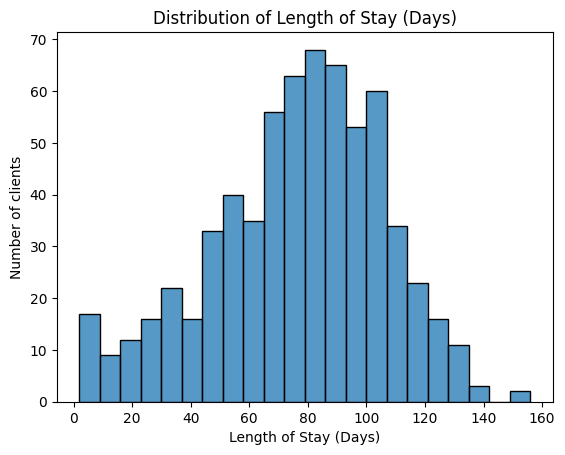

In [329]:
# plot the distribution of survival days
sns.histplot(y_train_val['survival_days'], binwidth = 7).set(
    title = 'Distribution of Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)',
    ylabel = 'Number of clients'
)

Text(0.5, 1.0, 'Survival Function of Successful Discharge')

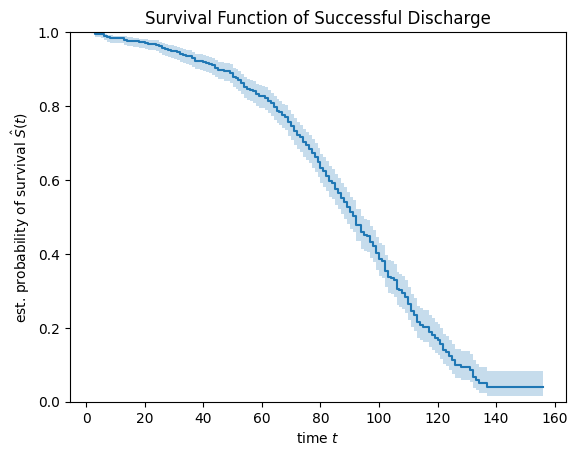

In [330]:
# use Kaplan-Meier estiamtor to plot the survival function
time, survival_prob, conf_int = kaplan_meier_estimator(
    y_train_val['discharge_flag'], 
    y_train_val["survival_days"], 
    conf_type = "log-log"
)

plt.step(time, survival_prob, where = "post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha = 0.25, step = "post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Function of Successful Discharge')

In [331]:
# create a function to plot survival functions by different variables
def plot_survival_function(X, y, col_name):

    for col in X[col_name].unique():
        mask = X[col_name] == col
        time, survival_prob, conf_int = kaplan_meier_estimator(
            y['discharge_flag'][mask],
            y["survival_days"][mask],
            conf_type = "log-log",
        )

        plt.step(time, survival_prob, where = "post", label = f"{col_name} = {col}")
        plt.fill_between(time, conf_int[0], conf_int[1], alpha = 0.25, step = "post")

    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc = "best")

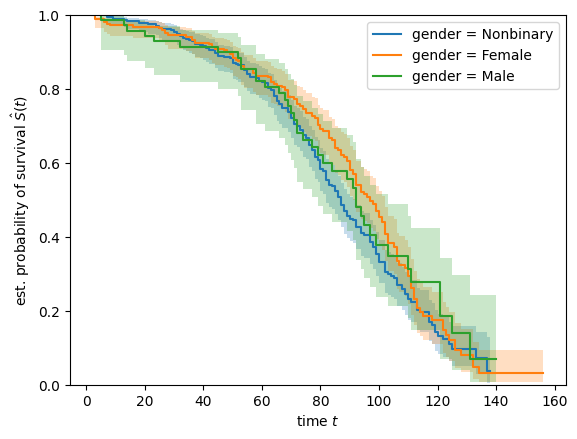

In [332]:
# for example, the survival function doesn't differ much by gender
plot_survival_function(X_train_val, y_train_val, 'gender')

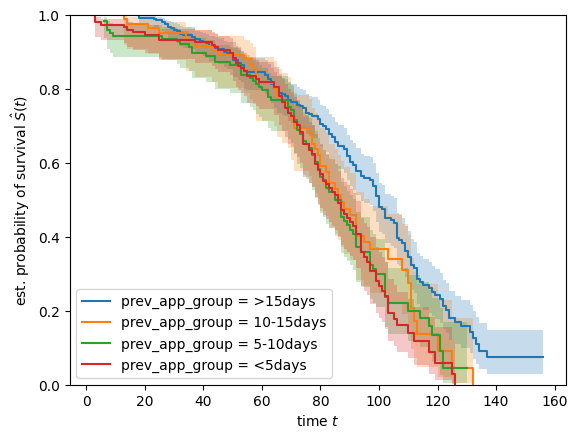

In [333]:
# But there seems to be difference of survival probability by days from previous appointment
X_train_val['prev_app_group'] = pd.cut(
    X_train_val['days_from_prev_app'], 
    bins = [0, 5, 10, 15, X_train_val['days_from_prev_app'].max()], 
    labels = ['<5days', '5-10days', '10-15days', '>15days'], 
    include_lowest = True
)

plot_survival_function(X_train_val, y_train_val, 'prev_app_group')

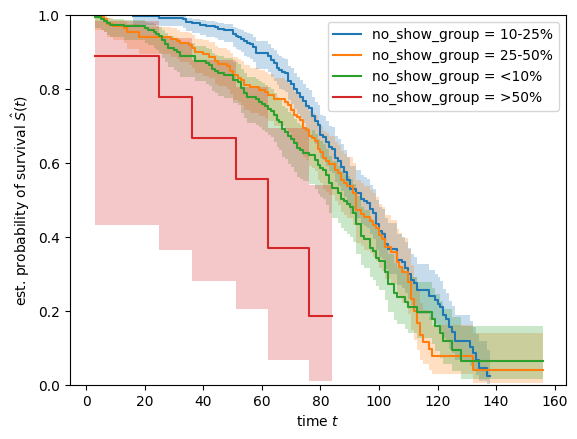

In [334]:
# There are definitely big differences in survival probability between % "No Show" appointments
X_train_val['no_show_group'] = pd.cut(
    X_train_val['no_show'], 
    bins = [0, 0.1, 0.25, 0.5, X_train_val['no_show'].max()], 
    labels = ['<10%', '10-25%', '25-50%', '>50%'], 
    include_lowest = True
)

plot_survival_function(X_train_val, y_train_val, 'no_show_group')

### Select the best model to predict a survival function of CH client for length of stay
There are 34 candidate features that can be leveraged to predict a survival probability for each CH client, and it is more efficient to build a model training pipeline from `sklearn` to streamline data preprocessing, feature selection and model hyperparameter tuning to eventually understand feature importance. The canddiate models are:
1. Cox regression (as a baseline)
2. Cox regression with penalty (Elastic Net)
3. Random survival forest
4. Gradient boossting machine for survival analysis
5. Component-wise GBM

<br>
Concordance index with right-censorship is usually the evaluation metric for survival model, but the censorship rate in the data set is ~38% and we care more about the predictability of the model, we need to use metrics that are robust to censorship and can distinguish model performances. We will use concordance index with IPCW and cumulative dynamic AUC score to evaluate the models

In [335]:
X_train_val = X_train_val.drop(columns = ['prev_app_group', 'no_show_group'])
X_train_val.shape, y_train_val.shape

((654, 33), (654,))

In [336]:
# Standardize the numeric variables
X_train_val = standardize(X_train_val)

### Select the model architecture
The function below is to select the model architecture to focus on. Based on time-dependent AUC score, GBM has the best AUC score on validation set

Finished Baseline Cox
Finished Elastic Net Cox
Finished RSF
Finished GBM
Finished Comp. GBM


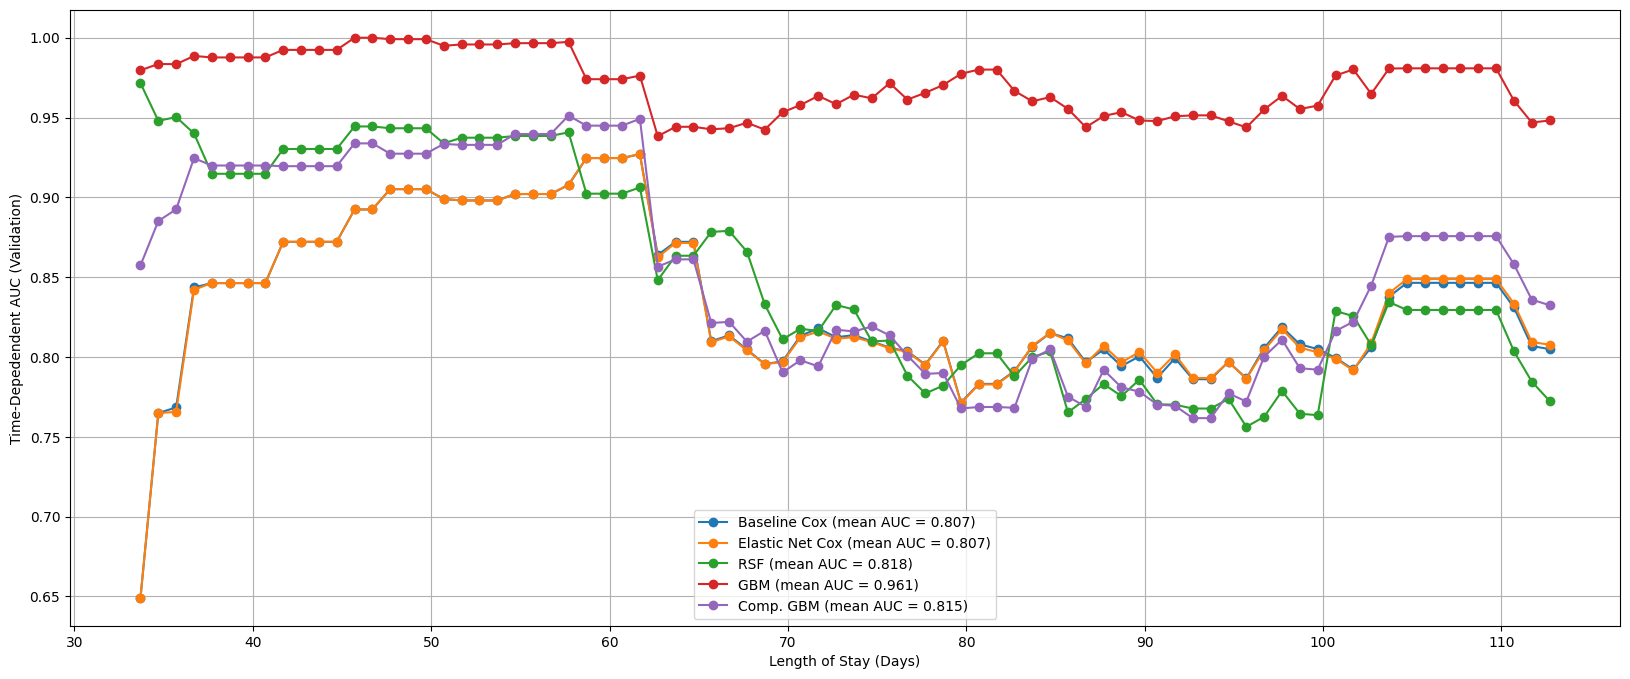

In [337]:
# select the best model architecture
candidate_models = {
    'Baseline Cox': CoxPHSurvivalAnalysis(), # baseline
    'Elastic Net Cox': CoxnetSurvivalAnalysis(fit_baseline_model=True), # Elastic Net 
    'RSF': RandomSurvivalForest(n_jobs = -1, random_state = 47),
    'GBM': GradientBoostingSurvivalAnalysis(random_state = 47),
    'Comp. GBM': ComponentwiseGradientBoostingSurvivalAnalysis()
}

# time limits of all data
lower, upper = np.percentile(y['survival_days'], [10, 90])
time_limit = np.arange(lower, upper + 1)

# train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 47)

# fit each model and report performance metrics
# metrics to consider: concordance index IPCW, cumulative dynamic AUC socre, integrated brier score

model_performance = {
    'model_name': [],
    'c_index_ipcw_train': [],
    'c_index_ipcw_validation': [],
    'mean_auc_train': [],
    'mean_auc_validation': [],
    'ibs_train': [],
    'ibs_validation': []
}

plt.figure(figsize = (20, 8))

for model_name, model in candidate_models.items():

    # create a pipeline
    pipeline = Pipeline([
        ('encoder', OneHotEncoder()),
        ('model', model)
    ])

    # fit the model and make predictions on train and validation sets
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_train_survs = pipeline.predict_survival_function(X_train)
    y_val_survs = pipeline.predict_survival_function(X_val)
    y_train_prob = np.row_stack([fn(time_limit) for fn in y_train_survs])
    y_val_prob = np.row_stack([fn(time_limit) for fn in y_val_survs])


    # calculate model performance metrics
    c_index_ipcw_train = concordance_index_ipcw(y_train, y_train, y_train_pred)
    c_index_ipcw_val = concordance_index_ipcw(y_train, y_val, y_val_pred)
    auc_train, mean_auc_train = cumulative_dynamic_auc(y_train, y_train, y_train_pred, time_limit)
    auc_val, mean_auc_val = cumulative_dynamic_auc(y_train, y_val, y_val_pred, time_limit)
    ibs_train = integrated_brier_score(y_train, y_train, y_train_prob, time_limit)
    ibs_val = integrated_brier_score(y_train, y_val, y_val_prob, time_limit)

    # plot AUC over time
    plt.plot(time_limit, auc_val, "o-", label = f"{model_name} (mean AUC = {mean_auc_val:.3f})")
    plt.xlabel("Length of Stay (Days)")
    plt.ylabel("Time-Depedendent AUC (Validation)")
    plt.legend(loc = "lower center")
    plt.grid(True)

    # create output
    model_performance['model_name'].append(model_name)
    model_performance['c_index_ipcw_train'].append(c_index_ipcw_train[0])
    model_performance['c_index_ipcw_validation'].append(c_index_ipcw_val[0])
    model_performance['mean_auc_train'].append(mean_auc_train)
    model_performance['mean_auc_validation'].append(mean_auc_val)
    model_performance['ibs_train'].append(ibs_train)
    model_performance['ibs_validation'].append(ibs_val)

    print(f'Finished {model_name}')

In [338]:
pd.DataFrame(model_performance).sort_values(by = 'mean_auc_validation', ascending = False)

model_name  c_index_ipcw_train  c_index_ipcw_validation  \
3              GBM            0.926539                 0.854764   
2              RSF            0.925372                 0.700596   
4        Comp. GBM            0.754602                 0.699941   
1  Elastic Net Cox            0.779886                 0.705542   
0     Baseline Cox            0.780468                 0.705085   

   mean_auc_train  mean_auc_validation  ibs_train  ibs_validation  
3        0.985433             0.961221   0.053854        0.066518  
2        0.982504             0.818159   0.051930        0.124440  
4        0.874913             0.814902   0.127334        0.124800  
1        0.884914             0.807443   0.101891        0.122737  
0        0.884433             0.807422   0.101763        0.122993

### Hyper-parameter tuning for GBM model
From the previous step, GBM model has the best performance in terms of time-dependent AUC score on validation data set. The following parameters are related to regularization of this model:
1. Loss: if "lpcsls", it is the same as Accelerated Time Failure model
2. learning_rate
3. dropout_rate
4. subsample

In [339]:
# tune the model with fixed number of features
X_train_val = standardize(X_train_val)

# One-hot encoder
one_hot = OneHotEncoder()
one_hot.fit(X_train_val)
X_train_val = one_hot.transform(X_train_val)

In [340]:
model = GradientBoostingSurvivalAnalysis(random_state = 47)

param_set = {
    'estimator__loss': ['coxph', 'ipcwls'],
    'estimator__learning_rate': [0, 0.01, 0.1, 1, 2],
    'estimator__dropout_rate': [0, 0.01, 0.1, 0.5],
    'estimator__subsample': [0.2, 0.5, 1]
}

In [ ]:
grid = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(model, times = time_limit),
    param_grid = param_set,
    cv = KFold(n_splits = 3, shuffle = True, random_state = 47),
    n_jobs = -1
).fit(X_train_val, y_train_val)

### Final model and evaluation on test data


In [342]:
results = pd.DataFrame(grid.cv_results_).sort_values(by = "mean_test_score", ascending = False)
results.loc[:, ~results.columns.str.endswith("_time")].head()

param_estimator__dropout_rate param_estimator__learning_rate  \
20                             0                              1   
50                          0.01                              1   
86                           0.1                              2   
56                          0.01                              2   
26                             0                              2   

   param_estimator__loss param_estimator__subsample  \
20                 coxph                          1   
50                 coxph                          1   
86                 coxph                          1   
56                 coxph                          1   
26                 coxph                          1   

                                               params  split0_test_score  \
20  {'estimator__dropout_rate': 0, 'estimator__lea...           0.980509   
50  {'estimator__dropout_rate': 0.01, 'estimator__...           0.970721   
86  {'estimator__dropout_rate': 0.1, 'estimator__l...           0.975196   
56  {'estimator__dropout_rate': 0.01, 'estimator__...           0.981730   
26  {'estimator__dropout_rate': 0, 'estimator__lea...           0.956265   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
20           0.985005           0.985610         0.983708        0.002276   
50           0.982032           0.981506         0.978086        0.005212   
86           0.975243           0.978641         0.976360        0.001613   
56           0.968371           0.977087         0.975729        0.005538   
26           0.971395           0.973984         0.967215        0.007815   

    rank_test_score  
20                1  
50                2  
86                3  
56                4  
26                5

In [343]:
# best model from CV
best_model = grid.best_estimator_

# Process the test data 
X_test = standardize(X_test)
X_test = one_hot.transform(X_test)

In [344]:
def model_eval(model):

    # make predictions on both train and test data
    y_train_val_pred = model.predict(X_train_val)
    y_train_val_survs = model.predict_survival_function(X_train_val)
    y_train_val_hazard = model.predict_cumulative_hazard_function(X_train_val)
    y_train_val_prob = np.row_stack([f(time_limit) for f in y_train_val_survs])

    y_test_pred = model.predict(X_test)
    y_test_survs = model.predict_survival_function(X_test)
    y_test_hazard = model.predict_cumulative_hazard_function(X_test)
    y_test_prob = np.row_stack([f(time_limit) for f in y_test_survs])

    # C-index IPCW
    c_index_ipcw_train = concordance_index_ipcw(y_train_val, y_train_val, y_train_val_pred)
    c_index_ipcw_test = concordance_index_ipcw(y_train_val, y_test, y_test_pred)

    # IBS
    ibs_train = integrated_brier_score(y_train_val, y_train_val, y_train_val_prob, time_limit)
    ibs_test = integrated_brier_score(y_train_val, y_test, y_test_prob, time_limit)

    # chart to show time-dependent AUC scores of train and test data
    auc_train_val, mean_auc_train_val = cumulative_dynamic_auc(y_train_val, y_train_val, y_train_val_pred, time_limit)
    auc_test, mean_auc_test = cumulative_dynamic_auc(y_train_val, y_test, y_test_pred, time_limit)

    plt.figure(figsize = (20, 8))
    plt.plot(time_limit, auc_train_val, "o-", label = f"Train (mean AUC = {mean_auc_train_val:.3f})")
    plt.plot(time_limit, auc_test, "o-", label = f"Test (mean AUC = {mean_auc_test:.3f})")
    plt.xlabel("Length of Stay (Days)")
    plt.ylabel("Time-Depedendent AUC (Validation)")
    plt.title('Model Performance Evaluation')
    plt.legend(loc = "lower right")
    plt.grid(True)

    print(pd.DataFrame({
        'metric_type': ['Train', 'Test'],
        'c_index-ipcw': [c_index_ipcw_train[0], c_index_ipcw_test[0]],
        'ibs': [ibs_train, ibs_test]
    }))

    return y_train_val_pred, y_train_val_survs, y_train_val_hazard, y_train_val_prob, c_index_ipcw_train, ibs_train, auc_train_val, mean_auc_train_val, y_test_pred, y_test_survs, y_test_hazard, y_test_prob, c_index_ipcw_test, ibs_test, auc_test, mean_auc_test

  metric_type  c_index-ipcw       ibs
0       Train      0.993987  0.022875
1        Test      0.785917  0.114400


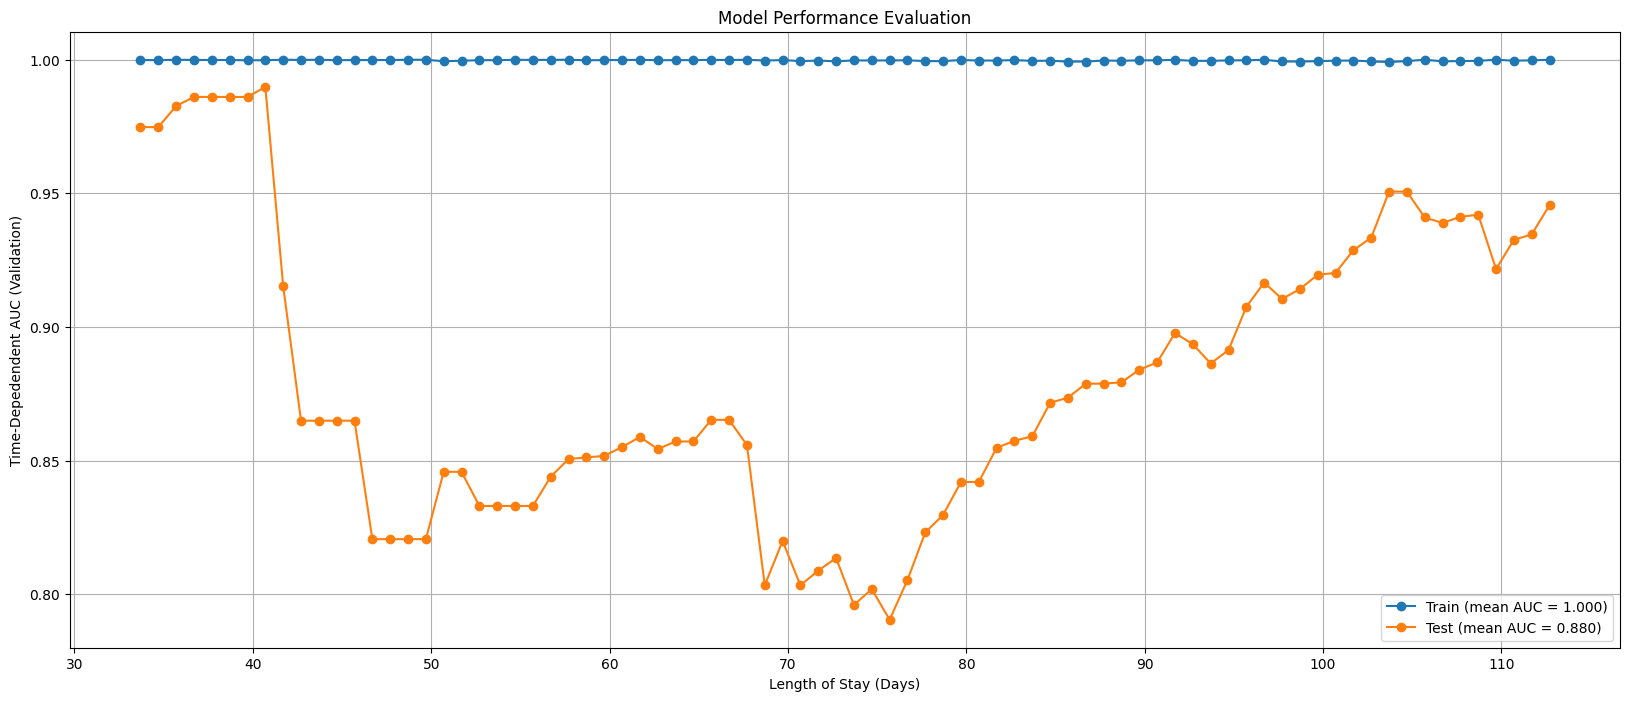

In [345]:
y_train_val_pred, y_train_val_survs, y_train_val_hazard, y_train_val_prob, c_index_ipcw_train, ibs_train, auc_train_val, mean_auc_train_val, y_test_pred, y_test_survs, y_test_hazard, y_test_prob, c_index_ipcw_test, ibs_test, auc_test, mean_auc_test = model_eval(best_model)

### Feature importance

In [346]:
feature_importance = best_model.estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

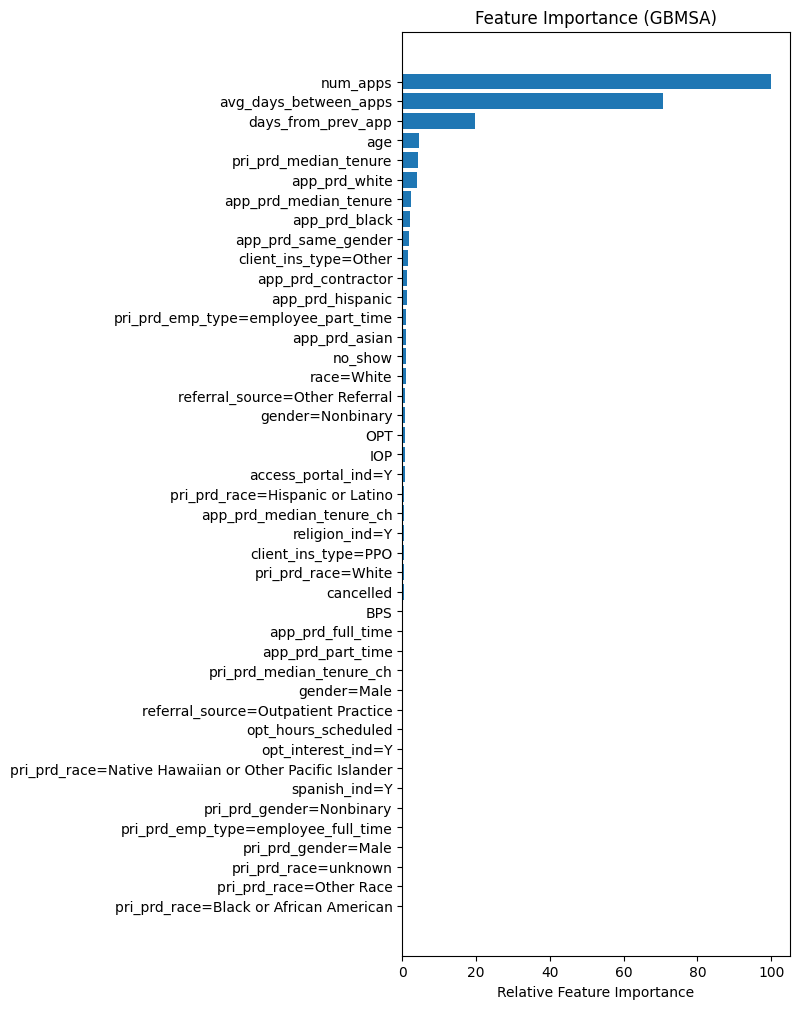

In [347]:
plt.figure(figsize = (5, 12))
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, X_test.keys()[sorted_idx])
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance (GBMSA)')
plt.show()

In [348]:
feature_importance_gbsa = permutation_importance(best_model, X_test, y_test, n_repeats = 15, random_state = 47)
permutation_importance_gbsa = pd.DataFrame(
    {
        k: feature_importance_gbsa[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index = X_test.columns,
).sort_values(by = "importances_mean", ascending = False)

permutation_importance_gbsa['relative_importance'] = (permutation_importance_gbsa['importances_mean'] / permutation_importance_gbsa['importances_mean'].max()) * 100

sorted_idx2 = np.argsort(permutation_importance_gbsa['relative_importance'])
pos2 = np.arange(sorted_idx2.shape[0]) + 0.5

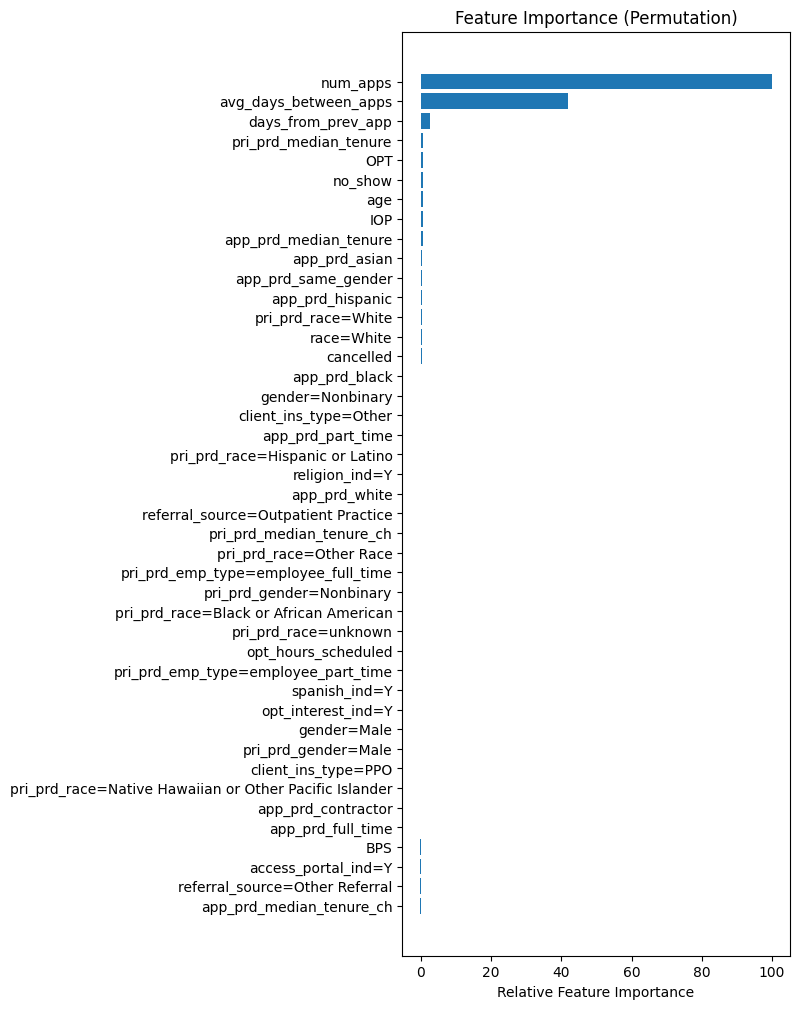

In [349]:
plt.figure(figsize = (5, 12))
plt.barh(pos2, permutation_importance_gbsa['relative_importance'][sorted_idx2], align = 'center')
plt.yticks(pos2, permutation_importance_gbsa.index[sorted_idx2])
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance (Permutation)')
plt.show()

### Add feature selection to improve the overfitting
1. The model performance evaluation metrics (C-index IPCW, cumulative dynamic AUC and IBS) showed that there is overfitting of data
2. Feature importance charts confirmed that the top 3 features of predictive power are # appointments, average days between appointments, and days from the previous appointment. If limiting the number of features on the model, would it improve the overall performance? 

In [350]:
# function for feature selection
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = best_model
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

# create a pipeline with feature selection function
pipe = Pipeline([
    ('feature_selection', SelectKBest(fit_and_score_features)),
    ('model', best_model)
])

params = {'feature_selection__k': [3, 5, 10, 15, 'all']}

grid_k = GridSearchCV(
    pipe,
    param_grid = params,
    cv = KFold(n_splits = 3, shuffle = True, random_state = 47),
    n_jobs = -1
).fit(X_train_val, y_train_val)

In [351]:
results_k = pd.DataFrame(grid_k.cv_results_).sort_values(by = "mean_test_score", ascending = False)
results_k.loc[:, ~results_k.columns.str.endswith("_time")].head()

param_feature_selection__k                           params  \
0                          3      {'feature_selection__k': 3}   
1                          5      {'feature_selection__k': 5}   
2                         10     {'feature_selection__k': 10}   
3                         15     {'feature_selection__k': 15}   
4                        all  {'feature_selection__k': 'all'}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.985207           0.995258           0.992884         0.991116   
1           0.986971           0.991852           0.989500         0.989441   
2           0.982836           0.990896           0.989128         0.987620   
3           0.980385           0.987509           0.986591         0.984828   
4           0.980509           0.985005           0.985610         0.983708   

   std_test_score  rank_test_score  
0        0.004290                1  
1        0.001993                2  
2        0.003459                3  
3        0.003164                4  
4        0.002276                5

In [352]:
best_model_k = grid_k.best_estimator_

In [353]:
final_feature_importance = pd.DataFrame(
    {
        'feature_name': pd.Series(best_model_k.steps[0][1].feature_names_in_[best_model_k.steps[0][1].get_support()]),
        'feature_importance': pd.Series(best_model_k.steps[1][1].estimator_.feature_importances_)
    }
)

final_feature_importance['relative_feature_importance'] = final_feature_importance['feature_importance'] / final_feature_importance['feature_importance'].max()
final_feature_importance.sort_values(by = 'relative_feature_importance', ascending = False)


feature_name  feature_importance  relative_feature_importance
1               num_apps            0.529115                     1.000000
0  avg_days_between_apps            0.450040                     0.850554
2                    IOP            0.020845                     0.039396

In [354]:
sorted_idx3 = np.argsort(final_feature_importance['relative_feature_importance'])
pos3 = np.arange(sorted_idx3.shape[0]) + 0.5

Text(0.5, 1.0, 'Feature Importance with SelectKBest')

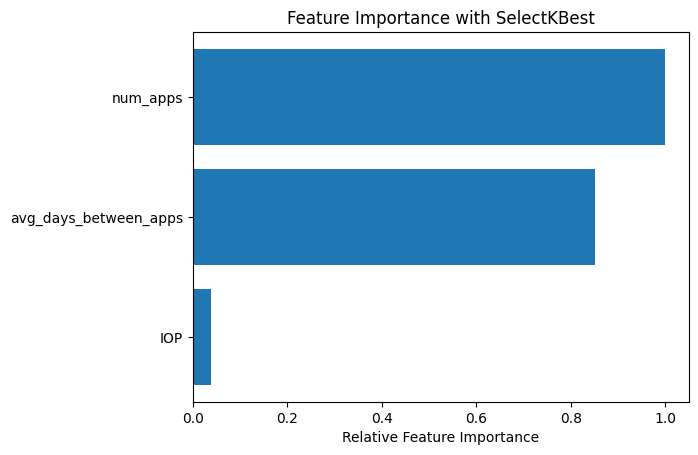

In [355]:
plt.barh(pos3, final_feature_importance['relative_feature_importance'][sorted_idx3], align = 'center')
plt.yticks(pos3, final_feature_importance['feature_name'][sorted_idx3])
plt.xlabel('Relative Feature Importance')
plt.title('Feature Importance with SelectKBest')

  metric_type  c_index-ipcw       ibs
0       Train      0.989649  0.034148
1        Test      0.764135  0.136134


(array([ 7.11916188e+00,  1.25511790e+00,  8.34468280e+00,  4.09197971e+00,
         1.49206688e+00, -2.71857744e+00,  2.04115326e+00,  9.34883493e-01,
         1.82714806e+01, -6.22458857e+00, -3.77763996e+00,  4.69975419e+00,
         6.35465697e+00, -2.61294355e+00,  9.57484335e+00, -6.99388376e-03,
         1.05488975e+01, -7.11347179e+00, -1.94879070e+00,  5.25545593e+00,
         6.37404890e-01,  6.89727522e+00,  2.79625052e+00, -7.24306942e-01,
         2.98762013e+00,  1.95868479e+00,  5.50110117e+00, -3.24396785e+00,
        -2.69864955e+00, -5.79817085e-01, -3.15712112e+00, -5.21120045e+00,
         7.11916188e+00,  6.99324590e-01, -1.10315847e+01,  1.62615069e+00,
        -8.72273785e-01, -7.99318272e+00, -2.90662865e+00,  2.34656887e+00,
         5.78691730e-01, -1.21423141e+01,  1.16174584e+01,  3.29800570e+00,
        -7.11347179e+00, -9.91075695e+00, -5.78808742e+00, -1.32506488e+01,
        -3.87431095e+00, -3.24396785e+00,  1.02222074e+00,  3.45701544e+00,
        -2.1

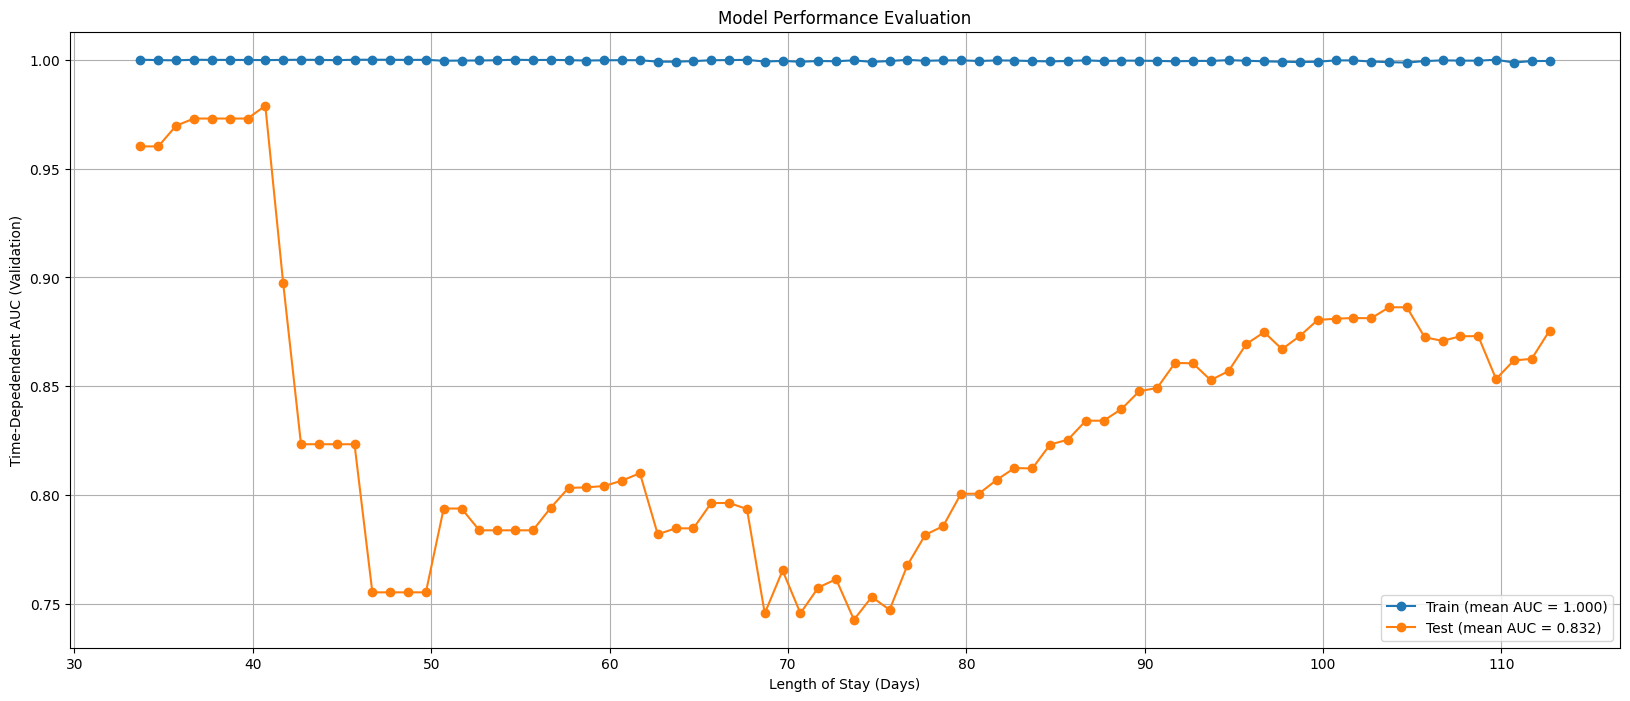

In [356]:
model_eval(best_model_k)

### How to use the survival model to make business decisions
With survival function, it is possible to calculate the survival probability of any given days in the future. For example, if we want to have a list of clients who might be discharged in the next 30 days, we can create an output using the survival function from the survival model. With that information, the care delivery team can make staffing decisions proactively to ensure better outcomes and experiences for the clients

Text(0.5, 1.0, 'Survival Functions of Discharge within 30 Days')

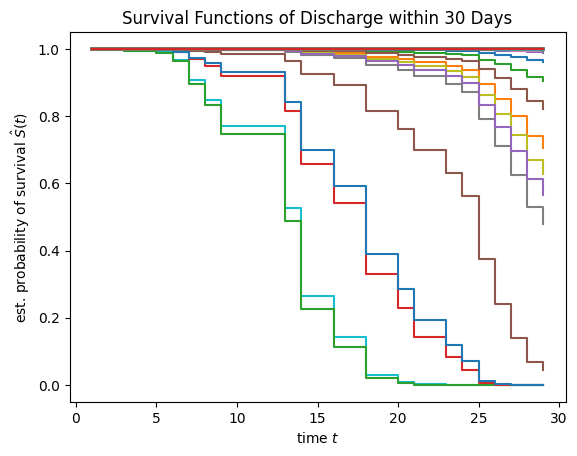

In [357]:
# plot survival functions within 30 days
time_points = np.arange(1, 30)
for i, surv_func in enumerate(y_test_survs):
    plt.step(time_points, surv_func(time_points), where = "post") 
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Functions of Discharge within 30 Days')

Text(0.5, 1.0, 'Cumulative Hazard Functions of Discharge within 30 Days')

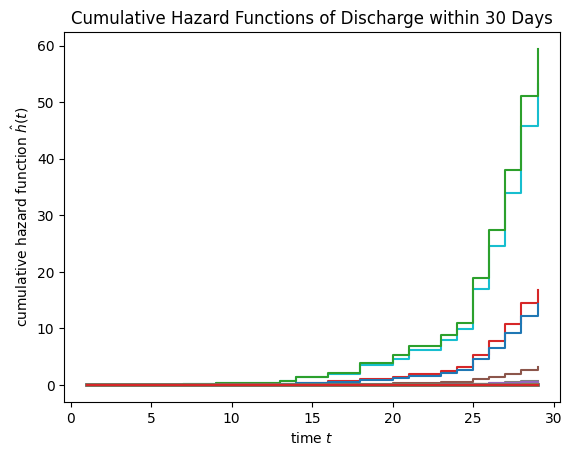

In [358]:
# plot hazard function within 30 days
for i, h_func in enumerate(y_test_hazard):
    plt.step(time_points, h_func(time_points), where = "post") 
plt.ylabel(r"cumulative hazard function $\hat{h}(t)$")
plt.xlabel("time $t$")
plt.title('Cumulative Hazard Functions of Discharge within 30 Days')

In [359]:
# function to create the output with customized days for probability of discharge
def create_discharge_prob_output(test_ids, survival_function, time_interval_days):
    probs = []
    for _, f in enumerate(survival_function):
        prob = f(time_interval_days)
        probs.append(prob)
    
    df_probs = pd.DataFrame(pd.Series(probs, name = f'survival_prob_{time_interval_days}_days'))
    return pd.concat([test_ids, df_probs], axis = 1)

In [360]:
test_ids = df.iloc[X_test.index, 0:2].reset_index(drop = True)
test_output_30_days = create_discharge_prob_output(test_ids, y_test_survs, 30)
test_output_30_days[test_output_30_days.survival_prob_30_days < 0.5].sort_values(by = 'survival_prob_30_days')

client_id  EOC_KEY_X  survival_prob_30_days
102  garciaashley@example.net9/29/2008    9926146           1.700542e-30
79   zacharypotter@example.net5/7/1998   11153834           2.169179e-27
103       brian86@example.com12/4/2006   11134949           3.857527e-09
120      edward93@example.net6/22/2002    9910619           7.089397e-08
55         mperez@example.com5/24/2010   11898107           2.810330e-02
87    michaelchen@example.com7/18/2002   12894889           4.267614e-01

In [361]:
pred_survival_days = []
for i in range(len(y_test_survs)):
    f = y_test_survs[i]
    for t in np.arange(1, 157):
        if f(t) == 0:
            pred_survival_days.append(t)
            break

df_pred_surv_days = pd.DataFrame(pd.Series(pred_survival_days, name = 'pred_survival_days'))
pred_survival_days_output = pd.concat([test_ids, df_pred_surv_days], axis = 1)
pred_survival_days_output['pred_survival_weeks'] = pred_survival_days_output.pred_survival_days // 7
pred_survival_days_output.sort_values(by = 'pred_survival_days').head(10)


client_id  EOC_KEY_X  pred_survival_days  \
102   garciaashley@example.net9/29/2008    9926146                  42   
79    zacharypotter@example.net5/7/1998   11153834                  42   
103        brian86@example.com12/4/2006   11134949                  49   
120       edward93@example.net6/22/2002    9910619                  50   
55          mperez@example.com5/24/2010   11898107                  54   
87     michaelchen@example.com7/18/2002   12894889                  62   
124         judy57@example.org6/12/2010   10143992                  64   
118  belindacurtis@example.net2/16/2003   10477769                  64   
1    lauragilbert@example.com12/27/2009    9409131                  65   
5           bryan55@example.org3/7/2003    9692695                  68   

     pred_survival_weeks  
102                    6  
79                     6  
103                    7  
120                    7  
55                     7  
87                     8  
124                    9  
118                    9  
1                      9  
5                      9

In [362]:
pred_survival_final_output = pd.merge(pred_survival_days_output, test_output_30_days, 'inner', on = ['client_id', 'EOC_KEY_X'])
pred_survival_final_output[pred_survival_final_output.survival_prob_30_days < 0.5].sort_values(by = ['survival_prob_30_days', 'pred_survival_weeks'], ascending = [True, True])

client_id  EOC_KEY_X  pred_survival_days  \
102  garciaashley@example.net9/29/2008    9926146                  42   
79   zacharypotter@example.net5/7/1998   11153834                  42   
103       brian86@example.com12/4/2006   11134949                  49   
120      edward93@example.net6/22/2002    9910619                  50   
55         mperez@example.com5/24/2010   11898107                  54   
87    michaelchen@example.com7/18/2002   12894889                  62   

     pred_survival_weeks  survival_prob_30_days  
102                    6           1.700542e-30  
79                     6           2.169179e-27  
103                    7           3.857527e-09  
120                    7           7.089397e-08  
55                     7           2.810330e-02  
87                     8           4.267614e-01

[Text(0.5, 1.0, 'Distribution of Predicted Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)')]

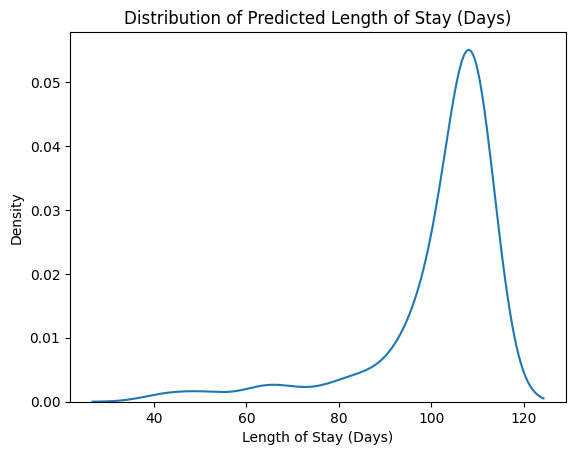

In [363]:
fig, ax = plt.subplots()
sns.kdeplot(pred_survival_final_output['pred_survival_days'], ax = ax).set(
    title = 'Distribution of Predicted Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)'
)

[Text(0.5, 1.0, 'Distribution of Predicted 30-day Survival Probability'),
 Text(0.5, 0, 'Survival Probability of 30 Days')]

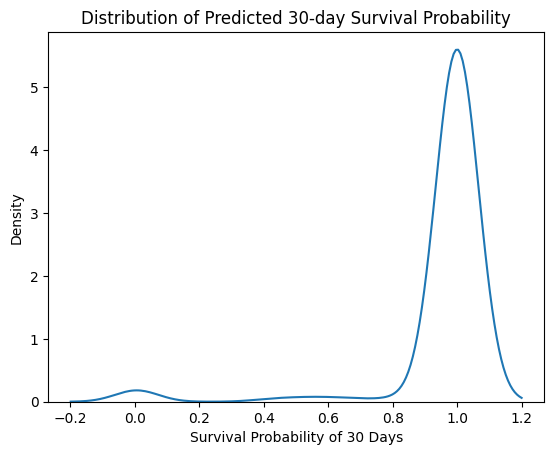

In [364]:
fig, ax = plt.subplots()
sns.kdeplot(pred_survival_final_output['survival_prob_30_days'], ax = ax).set(
    title = 'Distribution of Predicted 30-day Survival Probability',
    xlabel = 'Survival Probability of 30 Days'
)

[Text(0.5, 1.0, 'Distribution of Predicted Length of Stay (Days)'),
 Text(0.5, 0, 'Length of Stay (Days)'),
 Text(0, 0.5, 'Number of clients')]

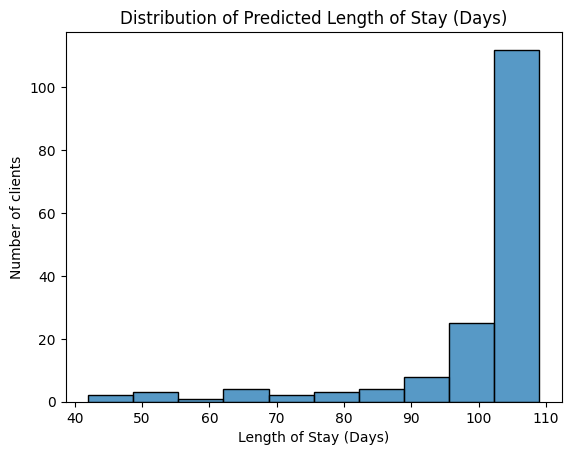

In [365]:
sns.histplot(pred_survival_final_output['pred_survival_days'], binwidth = 7).set(
    title = 'Distribution of Predicted Length of Stay (Days)',
    xlabel = 'Length of Stay (Days)',
    ylabel = 'Number of clients'
)

[Text(0.5, 1.0, 'Distribution of Predicted 30-Day Survival Probability'),
 Text(0.5, 0, 'Survival Probability of 30 Days')]

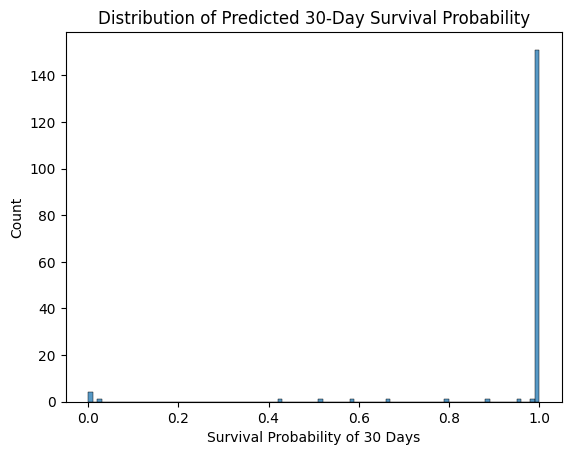

In [366]:
sns.histplot(pred_survival_final_output['survival_prob_30_days'], binwidth = 0.01).set(
    title = 'Distribution of Predicted 30-Day Survival Probability',
    xlabel = 'Survival Probability of 30 Days'
)